In [1]:
from pyspark.sql import SparkSession
from os import environ

In [ ]:
# environ.get('SPARK_JDBC')

In [2]:
SparkSession.builder.config('spark.driver.extraClassPath',environ.get('SPARK_JDBC')).getOrCreate()
spark = SparkSession.builder.appName('box_score_analysis').getOrCreate()

22/06/22 15:59:38 WARN Utils: Your hostname, rpi3 resolves to a loopback address: 127.0.1.1; using 172.25.14.38 instead (on interface wlan0)
22/06/22 15:59:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/22 16:00:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
query = 'select players.name as name, A.*  from '
query += '(select teams.name as team, box_scores.* from box_scores inner join teams on ' 
query += 'team_id = id) ' 
query += 'A inner join players on player_id = id'


df = spark.read.format('jdbc').option('url','jdbc:mysql://localhost:3306/nba').\
    option('user',environ.get('USER')).option('password',environ.get('PSWD')).\
    option('query',query).load()

In [4]:
df = df.drop('player_id','team_id')

Select scoring stats from the original df

In [170]:
scoring_stats = ['pts','fgm','fga','pm3','pa3','ftm','fta','ast']
identifiers = ['name','team']
label = ['result']
scoring_df = df[identifiers+label+scoring_stats]

Compute some derived scoring stats

In [171]:
scoring_df = scoring_df.withColumn('ft%', scoring_df.ftm/scoring_df.fta)
scoring_df = scoring_df.withColumn('fg%', scoring_df.fgm/scoring_df.fga)
scoring_df = scoring_df.withColumn('3p%', scoring_df.pm3/scoring_df.pa3)
scoring_df = scoring_df.withColumn('2p%', 
            (scoring_df.fgm - scoring_df.pm3)/(scoring_df.fga -scoring_df.pa3))
scoring_df = scoring_df.withColumn('eFG%', (scoring_df.fgm + 0.5*scoring_df.pm3)/scoring_df.fga)

In [172]:
from pyspark.ml.feature import StringIndexer

In [173]:
result_labler = StringIndexer(inputCol='result',outputCol='win',
                stringOrderType='alphabetAsc').fit(scoring_df)

In [174]:
scoring_df = result_labler.transform(scoring_df)

In [175]:
scoring_df.printSchema()

root
 |-- name: string (nullable = true)
 |-- team: string (nullable = true)
 |-- result: string (nullable = true)
 |-- pts: integer (nullable = true)
 |-- fgm: integer (nullable = true)
 |-- fga: integer (nullable = true)
 |-- pm3: integer (nullable = true)
 |-- pa3: integer (nullable = true)
 |-- ftm: integer (nullable = true)
 |-- fta: integer (nullable = true)
 |-- ast: integer (nullable = true)
 |-- ft%: double (nullable = true)
 |-- fg%: double (nullable = true)
 |-- 3p%: double (nullable = true)
 |-- 2p%: double (nullable = true)
 |-- eFG%: double (nullable = true)
 |-- win: double (nullable = false)



# Exploratory analysis

In [176]:
scoring_df[scoring_df.columns[3:]].toPandas().describe().round(4)

,pts,fgm,fga,pm3,pa3,ftm,fta,ast,ft%,fg%,3p%,2p%,eFG%,win
count,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,293686.0000,166381.0000,279167.0000,201886.0000,265440.0000,279167.0000,293686.000
mean,9.9248,3.6834,8.0747,0.9169,2.5699,1.6410,2.1493,2.1706,0.7519,0.4426,0.3258,0.4904,0.4972,0.501
std,8.1726,3.0578,5.7130,1.3216,2.7435,2.2736,2.7751,2.5061,0.2868,0.2363,0.3015,0.2813,0.2692,0.500
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000
25%,4.0000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.5000,0.3158,0.0000,0.3333,0.3333,0.000
50%,8.0000,3.0000,7.0000,0.0000,2.0000,1.0000,2.0000,1.0000,0.8333,0.4444,0.3333,0.5000,0.5000,1.000
75%,15.0000,5.0000,11.0000,1.0000,4.0000,2.0000,3.0000,3.0000,1.0000,0.5714,0.5000,0.6667,0.6667,1.000
max,70.0000,24.0000,50.0000,14.0000,24.0000,26.0000,39.0000,25.0000,1.0000,1.0000,1.0000,1.0000,1.5000,1.000


Summary statistics show:
- Teams have the same number of players
    - Because wins make up 50% of all records and only one team can win
    - There do not appear to be 'streamlined' teams in the NBA
    - Balanced class labels for wins/results, meaning downstream classification tasks do not need make extra considerations for unbalanced classes
- The average player contributes to points mostly through 2pt shots. (FGM and FGA mean and 50th percentile are comparable). They also contribute through free throws, making about one a game.
    - The average player takes few 3 pt shots and hardly makes any
- It seems that the average player takes about 2 3pt shots a game but most made threes are made by specialised/specialist players. This shows a skewness in 3PM that may need a log transform.
- Expected value of a 3pt shot is $3\times0.33 \approx$ 1. Expected value of a 2pt shot is $2\times0.49 \approx$ 1. Expected value of a free throw is $1\times0.75 = 0.75$
- There is also a slight skew in assists, that may indicate teams tend to rely on playmakers to make that final pass

It is possible that there will be null values as a result of zero division (not attempting to shoot). Effectively, if a player does not attempt a shot, their percentage is 0. The percentages should be used together with the attempts to distinguish between players who attempted but did not make a shot and others who did not attempt at all.

In [177]:
percentage_cols = [i for i in scoring_df.columns if '%' in i]
scoring_df = scoring_df.fillna(0,percentage_cols)

To further the exploratory analysis, I will attempt clustering to see what type of scorers exist in the NBA.

I employ k-means clustering, with $k=5$.

All columns will be scaled to range [0,1]. Percentage columns (with the exception of eFG% which is [0,1.5]) already follow this. This will prove useful for any clustering measures because feature vectors will be unit vectors and reduces the chances of the distance functions becoming intractible.

In [179]:
features = scoring_df.columns[3:-1]
to_scale = [i for i in features if  ('%' not in i) or i=='eFG%']
keep = [i for i in features if i not in to_scale]

Transformation stage

In [181]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

scale_assembler = VectorAssembler(inputCols=to_scale,outputCol='to_scale_features')
scoring_df = scale_assembler.transform(scoring_df)

keep_assembler = VectorAssembler(inputCols=keep,outputCol='unscaled_features')
scoring_df = keep_assembler.transform(scoring_df)



In [182]:
mm_scaler = MinMaxScaler(inputCol= 'to_scale_features', outputCol='scaled_features')
scaler = mm_scaler.fit(scoring_df)

scoring_df = scaler.transform(scoring_df)

In [183]:
assembler = VectorAssembler(inputCols=['scaled_features','unscaled_features'],outputCol = 'features')

scoring_df = assembler.transform(scoring_df)

With the features now ready, It is now possible to perform clustering. I will use K-Means with $2 <= k<= 13$ and select the best model with the elbow method after plotting the intracluster distance (or training cost) with respect to k.

In [184]:
from pyspark.ml.clustering import KMeans

Fitting the models

In [186]:
errors = []
models ={}
for k in range(2,14):
    kmeans = KMeans(featuresCol='features', k=k)
    model = kmeans.fit(scoring_df)
    models['k_'+str(k)] = model
    errors.append(model.summary.trainingCost)
    key = 'k_'+str(k)
    model_path =  "./kmeans_model_"+key
    model.save(model_path)
    # intra_distance =model.computeCost(scoring_df)
    # errors.append(intra_distance)

Plotting the results of training.

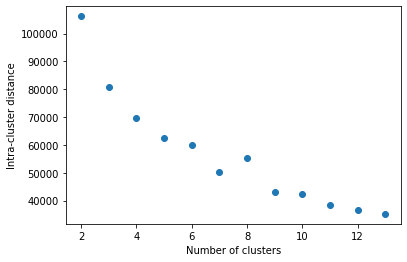

In [187]:
import matplotlib.pyplot as plt
cluster_number = range(2,14)
plt.xlabel('Number of clusters')
plt.ylabel('Intra-cluster distance')
plt.scatter(cluster_number,errors)
plt.show()

It appears that 7 clusters performs well enough

In [217]:
preds = models['k_7'].summary.predictions
# from pyspark.ml.clustering import KMeansModel
    

# model2 = KMeansModel.load(model_path)
# model2.hasSummary

/home/blunt/.local/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


A pivot table can now be made to count the wins and losses in each cluster and then calculate the win percentage within each cluster to see if there are any clusters that tend to have more winners.

In [219]:
pivot_table = preds.groupBy('prediction').pivot('result').count()
pivot_table.withColumn('win%',pivot_table.W/(pivot_table.L+pivot_table.W)).\
    show()

+----------+-----+-----+-------------------+
|prediction|    L|    W|               win%|
+----------+-----+-----+-------------------+
|         1|29731|26479| 0.4710727628535848|
|         6|17599|20100| 0.5331706411310645|
|         3| 9953|12531| 0.5573296566447251|
|         5|26707|26131|0.49454937734206444|
|         4|25238|22578| 0.4721850426635436|
|         2|21600|27855| 0.5632393084622384|
|         0|15707|11477|0.42219688051795173|
+----------+-----+-----+-------------------+



There does not appear to be a cluster or groups of clusters that contain players who consistently win.

It is possible to further analyse these clusters by checking if there are particular clusters that contain certain teams, describe the scoring statistics within these clusters, etc.

In [224]:
players = preds.select('name','team',*preds.columns[3:16],'prediction')

In [231]:
p_df = players.groupBy('prediction').avg().orderBy('prediction').toPandas()

In [232]:
p_df

,prediction,avg(pts),avg(fgm),avg(fga),avg(pm3),avg(pa3),avg(ftm),avg(fta),avg(ast),avg(ft%),avg(fg%),avg(3p%),avg(2p%),avg(eFG%),avg(prediction)
0,0,6.832291,1.756585,7.514751,0.640377,2.781158,2.678745,3.128715,2.257983,0.876686,0.209762,0.151808,0.186901,0.249513,0.0
1,1,1.241701,0.507419,3.131453,0.150525,1.176855,0.076339,0.242982,0.991550,0.030180,0.081508,0.038623,0.073538,0.093922,1.0
2,2,20.426469,7.040906,13.667374,2.599414,5.247518,3.745243,4.447154,3.710929,0.861644,0.531890,0.552274,0.527146,0.639005,2.0
3,3,12.183286,4.687066,6.806173,0.247420,1.136942,2.561733,3.389922,1.694405,0.789833,0.712695,0.067586,0.837062,0.731260,3.0
4,4,13.081249,4.779593,11.011523,0.276895,2.096892,3.245169,4.242157,2.815041,0.776906,0.434698,0.058552,0.515656,0.446767,4.0
5,5,6.745713,3.199005,6.240603,0.290605,1.574662,0.057099,0.382357,1.589689,0.013323,0.563573,0.067956,0.699546,0.582741,5.0
6,6,10.429905,4.093928,8.114671,2.140932,3.831348,0.101117,0.353192,2.125892,0.036011,0.540511,0.643502,0.383267,0.703947,6.0


In [234]:
top_scorers = preds.select('name','team',*preds.columns[3:16],'prediction').\
    filter(preds['prediction']==2).toPandas()#.show()

In [242]:
top_scorers.value_counts('name').sort_values()

name
Zoran Dragic        1
Earl Watson         1
Elijah Hughes       1
Gigi Datome         1
Gilbert Arenas      1
                 ... 
Damian Lillard    523
LeBron James      563
Kevin Durant      570
Stephen Curry     609
James Harden      669
Length: 994, dtype: int64

In [246]:
top_scorers.value_counts(['name','team'],normalize=True).sort_values().tail(20)

name                   team
Jayson Tatum           BOS     0.004792
Carmelo Anthony        NYK     0.004853
Donovan Mitchell       UTA     0.005015
Kyrie Irving           CLE     0.005156
Giannis Antetokounmpo  MIL     0.005237
Nikola Jokic           DEN     0.005257
Mike Conley            MEM     0.005257
Karl-Anthony Towns     MIN     0.005803
Devin Booker           PHX     0.005844
CJ McCollum            POR     0.006046
Kevin Durant           OKC     0.006147
Kemba Walker           CHA     0.006471
Khris Middleton        MIL     0.006632
Russell Westbrook      OKC     0.007057
Klay Thompson          GSW     0.007138
Kyle Lowry             TOR     0.007482
Bradley Beal           WAS     0.007886
Damian Lillard         POR     0.010575
James Harden           HOU     0.011101
Stephen Curry          GSW     0.012314
dtype: float64

In [ ]:
# ALS MODEL. DO RESEARCH ON IT!